# Final project: Activity Recognition

The final assignment is to implement a classifier for activity recognition based on data from the phone’s sensors.

For this task, first the acceleration using the sensors of a phone was recorded. Then an HMM classifier, that should be able to discriminate between standing still, walking and running, was implemented and its functionality verified.

In [1]:
%reload_ext autoreload
%autoreload 2

from PattRecClasses import DiscreteD, GaussD, HMM, MarkovChain
from DataHandler import DataHandler
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

### Data - Import and Pre-processing

In [2]:
# import

# Data for training

train = DataHandler('Train')
train_data = train.readFile()

train_stand = DataHandler('Stand')
train_stand_data = train_stand.readFile()
train_walk = DataHandler('Walk')
train_walk_data = train_walk.readFile()
train_run = DataHandler('Run')
train_run_data = train_run.readFile()



# Data for testing

test_stand = DataHandler('Stand2')
test_stand_data = test_stand.readFile()
test_stand2 = DataHandler('Stand3')
test_stand_data2 = test_stand2.readFile()
test_stand3 = DataHandler('Stand4')
test_stand_data3 = test_stand3.readFile()

test_walk = DataHandler('Walk2')
test_walk_data = test_walk.readFile()
test_walk2 = DataHandler('Walk3')
test_walk_data2 = test_walk2.readFile()
test_walk3 = DataHandler('Walk4')
test_walk_data3 = test_walk3.readFile()

test_run = DataHandler('Run2')
test_run_data = test_run.readFile()
test_run2 = DataHandler('Run3')
test_run_data2 = test_run2.readFile()
test_run3 = DataHandler('Run4')
test_run_data3 = test_run3.readFile()

test = DataHandler('Test')
test_data = test.readFile()

### Characterize output distributions: mean and covariance matrix

In [3]:
# g1 - standing
mean_stand = np.mean(train_stand_data, axis = 0)
centered_data = train_stand_data - mean_stand
cov_stand = np.dot(centered_data.T, centered_data) / (len(train_stand_data) - 1)

# g2 - walking
mean_walk = np.mean(train_walk_data, axis = 0)
centered_data = train_walk_data - mean_walk
cov_walk = np.dot(centered_data.T, centered_data) / (len(train_walk_data) - 1)

# g3 - running
mean_run = np.mean(train_run_data, axis = 0)
centered_data = train_run_data - mean_run
cov_run = np.dot(centered_data.T, centered_data) / (len(train_run_data) - 1)

### Create and initialize HMM

In [4]:
# infinite HMM, with three states: standing (S1), walking (S2), running (S3)

q = np.array([1/3, 1/3, 1/3])
A  = np.array([[0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
mc = MarkovChain(q, A) 

g1 = GaussD(means=mean_stand, cov = cov_stand)  # Distribution for state 'standing'
g2 = GaussD(means=mean_walk, cov = cov_walk)    # Distribution for state 'walking'
g3 = GaussD(means=mean_run, cov = cov_run)      # Distribution for state 'running'
h  = HMM(mc, [g1, g2, g3])                      # The HMM

### Train HMM

In [5]:
h.train(train_data)

# set q back to equal probabilities: test sequences can start with any state
h.stateGen.q = np.array([1/3, 1/3, 1/3])

### Verify HMM by isolated activities and one sequence containg all

In [6]:
# standing
states_stand = h.viterbi(test_stand_data).reshape(-1, 1)
states_stand2 = h.viterbi(test_stand_data2).reshape(-1, 1)
states_stand3 = h.viterbi(test_stand_data3).reshape(-1, 1)
standing = np.concatenate((states_stand, states_stand2, states_stand3))

count = 0
for t in range(len(standing)):
    if standing[t] != 0:
        count += 1       
        
accuracy = (len(standing) - count)/len(standing)
print('Accuracy:', accuracy)


Accuracy: 1.0


In [7]:
# walking
states_walk = h.viterbi(test_walk_data).reshape(-1, 1)
states_walk2 = h.viterbi(test_walk_data2).reshape(-1, 1)
states_walk3 = h.viterbi(test_walk_data3).reshape(-1, 1)
walking = np.concatenate((states_walk, states_walk2, states_walk3))

count = 0
for t in range(len(walking)):
    if walking[t] != 1:
        count += 1
accuracy = (len(walking) - count)/len(walking)
print('Accuracy:', accuracy)

Accuracy: 0.8561643835616438


In [8]:
# running
states_run = h.viterbi(test_run_data).reshape(-1, 1)
states_run2 = h.viterbi(test_run_data2).reshape(-1, 1)
states_run3 = h.viterbi(test_run_data3).reshape(-1, 1)
running = np.concatenate((states_run, states_run2, states_run3))

count = 0
for t in range(len(running)):
    if running[t] != 2:
        count += 1
accuracy = (len(running) - count)/len(running)
print('Accuracy:', accuracy)

Accuracy: 0.9376053962900506


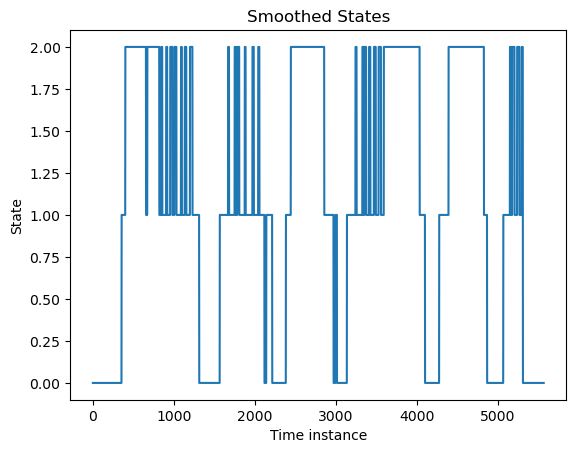

In [9]:
# sequence: 5 sec of each state
states_test = h.viterbi(test_data).reshape(-1, 1)

# apply majority filter to filter outliers
def majority_filter(seq, window_size):
    filtered = np.zeros(len(seq))
    for i in range(len(seq)):
        start = max(0, i - window_size // 2)
        end = min(len(seq), i + (window_size // 2) + 1)
        filtered[i] = np.bincount(seq[start:end, 0].astype(int)).argmax()
    return filtered

smoothed_states = majority_filter(states_test, window_size=20)

# Plot smoothed states
plt.plot(smoothed_states)
plt.xlabel('Time instance')
plt.ylabel('State')
plt.title('Smoothed States')
plt.show()